In [549]:
import torch
import torch.nn.functional as F
from torchtext import data
from torchtext import datasets
import time
import random
import pandas as pd
import numpy as np

torch.backends.cudnn.deterministic = True

In [550]:
df = pd.read_excel('../input/ciao9cci/politica.xlsx', sheet_name="Foglio1")
pd.options.display.float_format = '{:,.0f}'.format
print(f'Found {len(df)} texts.')

print(f'{df["cap_maj_master"].isnull().sum()} document(s) with no classification removed')
df=df[pd.notnull(df['cap_maj_master'])]

print(f'{df["testo"].isnull().sum()} document(s) with no text removed')
df=df[pd.notnull(df['testo'])]

classes = [int(c) for c in df['cap_maj_master']]
documents = [d for d in df['testo']]
df = df[['cap_maj_master', 'testo']]
df.columns = ['classlabel', 'content']
#df['classlabel'] = pd.factorize(df['classlabel'])[0]
df.classlabel = df.classlabel.astype(int)

Found 5674 texts.
2 document(s) with no classification removed
424 document(s) with no text removed


In [551]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df['classlabel'])
labels=le.transform(df['classlabel'])
print(np.unique(labels))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


In [552]:
num_class=len(np.unique(labels))
target_names=np.unique(labels)
print(num_class)

21


In [553]:
RANDOM_SEED = 123
torch.manual_seed(RANDOM_SEED)

VOCABULARY_SIZE = 5000
LEARNING_RATE = 1e-3
BATCH_SIZE = 50
NUM_EPOCHS = 50
DROPOUT = 0.5
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

EMBEDDING_DIM = 128
BIDIRECTIONAL = False
HIDDEN_DIM = 256
NUM_LAYERS = 2
OUTPUT_DIM = num_class

In [554]:
import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize 
def preprocessor(text):
    text = re.sub('<[^>]*>', ' ', str(text))
    text=re.sub('\d+',' ',str(text))
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                           str(text))
    text = (re.sub('[\W]+', ' ', text.lower()) + ' ' +
            ' '.join(emoticons).replace('-', ''))
    return text
import unicodedata
def strip_accents(text):
    try:
        text = unicode(text, 'utf-8')
    except NameError: # unicode is a default on python 3 
        pass

    text = unicodedata.normalize('NFD', text)\
           .encode('ascii', 'ignore')\
           .decode("utf-8")
    return text
def tokenizer_porter(text):
    stop=set(stopwords.words('italian'))
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w in stop]
    
    stemmer = SnowballStemmer("italian", ignore_stopwords=True)
    return [stemmer.stem(word) for word in filtered_sentence]

In [555]:
df['content']=df.content.apply(preprocessor).apply(strip_accents)
df['classlabel']=labels
df.head(3)

,classlabel,content
0,0,quali siano le determinazioni del governo in ...
1,0,quali siano le valutazioni del governo sugli ...
2,0,premesso che la prospettata modifica degli sc...


In [556]:
df[['classlabel', 'content']].to_csv('./train_prepocessed.csv', index=None)

In [557]:
del df

In [558]:
TEXT = data.Field(sequential=True,
                  tokenize=tokenizer_porter,
                  include_lengths=True) # necessary for packed_padded_sequence

LABEL = data.LabelField(dtype=torch.float)

In [559]:
fields = [('classlabel', LABEL), ('content', TEXT)]

dataset = data.TabularDataset(
    path="./train_prepocessed.csv", format='csv',
    skip_header=True, fields=fields)



In [560]:
TEXT.build_vocab(dataset,
                 max_size=VOCABULARY_SIZE,
                 vectors='fasttext.simple.300d',
                 unk_init=torch.Tensor.normal_)

LABEL.build_vocab(dataset)

print(f'Vocabulary size: {len(TEXT.vocab)}')
print(f'Number of classes: {len(LABEL.vocab)}')

Vocabulary size: 5002
Number of classes: 21


In [561]:

import torch.nn as nn


class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, bidirectional, hidden_dim, num_layers, output_dim, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx=pad_idx)
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim,
                           num_layers=num_layers,
                           bidirectional=bidirectional, 
                           dropout=dropout)
        self.fc1 = nn.Linear(hidden_dim * num_layers, 64)
        self.fc2 = nn.Linear(64, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
    def forward(self, text, text_length):

        embedded = self.dropout(self.embedding(text))
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_length)
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        # output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        hidden = self.relu(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        hidden = self.fc1(hidden)
        hidden = self.dropout(hidden)
        hidden = self.fc2(hidden)
        return hidden

In [562]:
def evaluate(model, data_loader, criterion):
    model.eval()
    val_accuracy = []
    val_loss = []
    with torch.no_grad():
        for batch_idx, batch_data in enumerate(data_loader):
            text, text_lengths = batch_data.content
            logits = model(text, text_lengths)
            loss = criterion(logits, batch_data.classlabel.long())
            val_loss.append(loss.item())
            
            _, preds = torch.max(logits, 1)
            accuracy = (preds == batch_data.classlabel.long()).cpu().numpy().mean() * 100
            val_accuracy.append(accuracy)
        val_loss = np.mean(val_loss)
        val_accuracy = np.mean(val_accuracy)
        return val_loss, val_accuracy

In [563]:
import random
import time



def set_seed(seed_value=42):
    """Set seed for reproducibility."""

    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
def train(model, optimizer,criterion, train_dataloader, val_dataloader=None, epochs=10):
    """Train the LSTM model."""
    
    # Tracking best validation accuracy
    best_accuracy = 0

    # Start training loop
    print("Start training...\n")
    print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
    print("-"*60)
    countdown=epochs
    count=1
    while countdown>0:
        # =======================================
        #               Training
        # =======================================

        # Tracking time and loss
        t0_epoch = time.time()
        total_loss = 0
        model.train()
        step=1
        for batch_idx, batch_data in enumerate(train_loader):
            text, text_lengths = batch_data.content
        
            ### FORWARD AND BACK PROP
            logits = model(text, text_lengths)
            loss = criterion(logits, batch_data.classlabel.long())
            total_loss += loss.item()
            optimizer.zero_grad()
            step=step+1
            loss.backward()
        
            ### UPDATE MODEL PARAMETERS
            optimizer.step()
        
        avg_train_loss = total_loss / len(train_dataloader)
        
        val_loss, val_accuracy = evaluate(model, val_dataloader,criterion)
        
        # Track the best accuracy
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), 'tut5-model.pt')
            countdown=epochs
        else:
            countdown=countdown-1
        time_elapsed = time.time() - t0_epoch
        print(f"{count :^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
        count=count+1
    print("\n")
    print(f"Training complete! Best accuracy: {best_accuracy:.2f}%.")
    return best_accuracy
    
        

In [564]:
from sklearn.model_selection import StratifiedKFold
n_folds=10
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=RANDOM_SEED)
labels = [example.classlabel for example in dataset]

In [565]:
from torch.utils.data.dataset import Subset
class TorchtextSubset(Subset):
    def __init__(self, dataset, indices):
        super(TorchtextSubset, self).__init__(dataset, indices)
        self.fields = self.dataset.fields
        self.sort_key = self.dataset.sort_key

In [566]:


def predict_class(model, sentence, min_len=4):
    # Somewhat based on
    # https://github.com/bentrevett/pytorch-sentiment-analysis/
    # blob/master/5%20-%20Multi-class%20Sentiment%20Analysis.ipynb
    model.eval()
    tokenized = [tok for tok in tokenizer_porter(sentence)]
    print(tokenized)
    if len(tokenized) < min_len:
        tokenized += ['<pad>'] * (min_len - len(tokenized))
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(DEVICE)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    preds = model(tensor, length_tensor)
    preds = torch.softmax(preds, dim=1)
    
    proba, class_label = preds.max(dim=1)
    return proba.item(), class_label.item()

In [567]:
def predictTen(model, tokenizers,min_len=4):
    
    labels=[]
    for batch_idx, tokenized in enumerate(tokenizers):
        model.eval()
        if len(tokenized) < min_len:
            tokenized += ['<pad>'] * (min_len - len(tokenized))
        indexed = [TEXT.vocab.stoi[t] for t in tokenized]
        length = [len(indexed)]
        tensor = torch.LongTensor(indexed).to(DEVICE)
        tensor = tensor.unsqueeze(1)
        length_tensor = torch.LongTensor(length)
        preds = model(tensor, length_tensor)
        preds = torch.softmax(preds, dim=1)

        _, class_label = preds.max(dim=1)            
        labels.append(class_label.item())
    return labels

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   2.865188   |  2.779603  |   13.64   |   4.64   
   2    |   2.764267   |  2.694112  |   18.55   |   4.68   
   3    |   2.676521   |  2.647253  |   21.45   |   4.62   
   4    |   2.554125   |  2.555044  |   26.55   |   4.63   
   5    |   2.453902   |  2.559362  |   27.27   |   4.72   
   6    |   2.382991   |  2.668756  |   21.82   |   4.85   
   7    |   2.288689   |  2.385798  |   30.91   |   4.80   
   8    |   2.247374   |  2.400381  |   30.91   |   4.67   
   9    |   2.077318   |  2.249173  |   35.45   |   4.66   
  10    |   2.035139   |  2.140765  |   40.36   |   4.62   
  11    |   1.891579   |  2.256650  |   41.45   |   4.63   
  12    |   1.792832   |  2.007010  |   46.55   |   4.77   
  13    |   1.697435   |  2.240138  |   41.82   |   4.63   
  14    |   1.709951   |  2.047792  |   45.82   |   4.71   
  15    |   1.716735

['premess', 'sab', 'gennai', 'piazzal', 'supermerc', 'indun', 'olon', 'vares', 'due', 'guard', 'giur', 'istit', 'vigil', 'stat', 'uccis', 'alcun', 'rapin', 'mentr', 'terz', 'guard', 'miracol', 'riusc', 'scapp', 'tal', 'assalt', 'giudic', 'prim', 'indagin', 'stat', 'organizz', 'minim', 'particolar', 'band', 'special', 'quest', 'episod', 'sintom', 'emblem', 'situazion', 'critic', 'ordin', 'pubblic', 'tutt', 'provinc', 'vares', 'qual', 'inform', 'dispong', 'ordin', 'conclusion', 'oggi', 'arriv', 'indagin', 'qual', 'provved', 'intend', 'adott', 'rid', 'sicurezz', 'abit', 'provinc', 'vares']
['premess', 'articol', 'decret', 'legisl', 'april', 'n', 'contien', 'riclassif', 'zon', 'svantagg', 'comm', 'preved', 'minister', 'polit', 'agricol', 'formul', 'propost', 'bas', 'comit', 'interministerial', 'programm', 'econom', 'determiner', 'misur', 'agevol', 'prim', 'propost', 'minister', 'fond', 'prevalent', 'criter', 'giacitur', 'suol', 'rifer', 'pendenz', 'med', 'territor', 'comunal', 'ricev', 'mo

['premess', 'oner', 'soggett', 'proprietar', 'cas', 'ital', 'rilev', 'entit', 'var', 'natur', 'dov', 'somm', 'ingent', 'spes', 'necessar', 'manutenzion', 'ordinar', 'straordinar', 'immobil', 'conger', 'form', 'imposizion', 'dirett', 'indirett', 'colleg', 'possess', 'cas', 'elimin', 'residu', 'quot', 'tassazion', 'irpef', 'prim', 'cas', 'piu', 'occasion', 'promess', 'ministr', 'finanz', 'stess', 'evoc', 'misur', 'considerevol', 'import', 'realt', 'tard', 'adegu', 'ital', 'ordin', 'tributar', 'maggior', 'nazion', 'europe', 'ove', 'previst', 'alcun', 'tassazion', 'redd', 'figur', 'quind', 'inesistent', 'cas', 'abit', 'tantomen', 'dopp', 'tassazion', 'medesim', 'ben', 'impost', 'redd', 'patrimon', 'avvien', 'ital', 'irpef', 'ici', 'attenzion', 'pes', 'grav', 'immobil', 'dovrebb', 'ogni', 'cas', 'esser', 'approfond', 'dov', 'ten', 'cont', 'oltre', 'trib', 'piu', 'immed', 'percezion', 'qual', 'irpef', 'irpeg', 'ici', 'impost', 'registr', 'succession', 'donazion', 'tass', 'rif', 'ecc', 'form'

['premess', 'occasion', 'corte', 'pacif', 'svoltos', 'sab', 'marz', 'padov', 'stat', 'lanc', 'fumogen', 'bengal', 'local', 'sed', 'alleanz', 'nazional', 'provoc', 'princip', 'incend', 'dannegg', 'porton', 'd', 'ingress', 'assalt', 'sed', 'alleanz', 'nazional', 'avven', 'lanc', 'uov', 'vernic', 'part', 'grupp', 'didisobbedient', 'com', 'not', 'facent', 'cap', 'signor', 'luc', 'casarin', 'ancor', 'volt', 'colt', 'occasion', 'dar', 'luog', 'episod', 'violenz', 'manifest', 'attacc', 'prefettur', 'alcun', 'banc', 'local', 'mcdonald', 's', 'giorn', 'scors', 'appars', 'scritt', 'intimid', 'confront', 'assessor', 'alleanz', 'nazional', 'poliz', 'municipal', 'onorevol', 'mauriz', 'sai', 'firm', 'sedicent', 'grupp', 'estrem', 'sinistr', 'extraparlament', 'attacc', 'marz', 'sed', 'alleanz', 'nazional', 'terz', 'stess', 'settiman', 'dop', 'devast', 'sed', 'azion', 'giovan', 'mass', 'carrar', 'avven', 'marz', 'bomb', 'fatt', 'esplod', 'giorn', 'dop', 'circol', 'capannon', 'provinc', 'pis', 'giorn',

['premess', 'articol', 'decret', 'legg', 'n', 'settembr', 'coordin', 'legg', 'conversion', 'novembr', 'n', 'preved', 'concession', 'assegn', 'par', 'eur', 'ogni', 'figl', 'second', 'od', 'ulterior', 'ordin', 'nasc', 'nat', 'dicembr', 'fin', 'dicembr', 'qual', 'oggi', 'risult', 'effett', 'efficac', 'tal', 'disposizion', 'fortement', 'vol', 'grupp', 'parlament', 'udc']
['premess', 'notiz', 'stamp', 'apprend', 'ultim', 'allarm', 'filon', 'eversion', 'intern', 'arriv', 'attravers', 'uffic', 'sisd', 'person', 'cap', 'dipart', 'analis', 'intelligenc', 'civil', 'dottor', 'alfred', 'mantic', 'cors', 'convegn', 'ten', 'prim', 'giorn', 'mes', 'ottobr', 'sicil', 'ampli', 'nuov', 'inquiet', 'particolar', 'scarn', 'indic', 'forn', 'serviz', 'segret', 'relazion', 'parl', 'estat', 'afferm', 'testual', 'cheogg', 'ital', 'esist', 'energ', 'evers', 'molt', 'organizz', 'radic', 'soprattutt', 'asse', 'pedemont', 'mil', 'torin', 'present', 'vecc', 'milit', 'part', 'armat', 'campagn', 'reclut', 'alcun', 'ce

['premess', 'dat', 'dicembr', 'consigl', 'ministr', 'deliber', 'sciogl', 'consigl', 'comunal', 'pozzuol', 'provinc', 'napol', 'accert', 'form', 'ingert', 'part', 'criminal', 'organizz', 'piu', 'volt', 'stat', 'denunc', 'interrog', 'parlamentar', 'camer', 'deput', 'n', 'sen', 'repubbl', 'n', 'intent', 'second', 'interrog', 'persecutor', 'confront', 'cit', 'amministr', 'comunal', 'part', 'alcun', 'istitu', 'particol', 'commission', 'd', 'access', 'nonost', 'stess', 'lavor', 'quas', 'due', 'anni', 'emers', 'rapport', 'parentel', 'rapport', 'dirett', 'indirett', 'amministr', 'consiglier', 'comunal', 'esponent', 'criminal', 'organizz', 'fatt', 'piu', 'grav', 'riman', 'diffusion', 'integral', 'organ', 'stamp', 'notiz', 'conten', 'relazion', 'commission', 'atto', 'riserv', 'avven', 'ennesim', 'dimostr', 'inadeguatezz', 'attual', 'normat', 'relat', 'sciogl', 'antimaf', 'comun', 'risc', 'compromett', 'lott', 'maf', 'vit', 'democrat', 'enti', 'local', 'qual', 'provved', 'assunt', 'intend', 'assu

['premess', 'convenzion', 'protezion', 'alpi', 'otto', 'stat', 'firmatar', 'impegn', 'salvaguard', 'lung', 'termin', 'ecosistem', 'natural', 'alpi', 'svilupp', 'sosten', 'nonc', 'tutel', 'interess', 'econom', 'popol', 'resident', 'stabil', 'princip', 'dovr', 'ispir', 'cooper', 'transfrontalier', 'paes', 'arco', 'alpin', 'raggiung', 'tal', 'obiett', 'part', 'contraent', 'dovrann', 'prend', 'adegu', 'misur', 'div', 'camp', 'd', 'azion', 'qual', 'attual', 'stat', 'pattu', 'nov', 'protocoll', 'attuat', 'ratif', 'protocoll', 'trasport', 'oggi', 'consider', 'essenzial', 'scelt', 'strateg', 'relat', 'polit', 'mobil', 'alpi', 'aument', 'traffic', 'va', 'conten', 'ser', 'misur', 'adegu', 'estemporane', 'firm', 'protocoll', 'question', 'alto', 'adig', 'inter', 'are', 'alpin', 'import', 'fondamental', 'xiv', 'legislatur', 'camer', 'deput', 'approv', 'sed', 'prim', 'terz', 'lettur', 'disegn', 'legg', 'autorizz', 'ratif', 'nov', 'protocoll', 'attuat', 'nonost', 'fatt', 'alcun', 'forz', 'allor', 'ma

['premess', 'comm', 'articol', 'legg', 'finanziar', 'attribu', 'govern', 'propost', 'ministr', 'interrog', 'concert', 'ministr', 'econom', 'finanz', 'comp', 'eman', 'piu', 'regol', 'riordin', 'semplif', 'razionalizz', 'organ', 'prepost', 'definizion', 'ricors', 'mater', 'pensionist', 'fin', 'ridurr', 'spes', 'funzion', 'pubblic', 'amministr', 'dop', 'prim', 'orient', 'emers', 'test', 'originar', 'disegn', 'legg', 'govern', 'articol', 'conferm', 'prim', 'lettur', 'camer', 'deput', 'volt', 'abolizion', 'comit', 'central', 'regional', 'provincial', 'inps', 'comit', 'vigil', 'gestion', 'inpdap', 'comm', 'stess', 'legg', 'finanziar', 'poi', 'disciplin', 'question', 'relat', 'stabilizz', 'personal', 'pubblic', 'amministr', 'qual', 'rientr', 'inps', 'inpdap', 'qual', 'stat', 'previst', 'possibil', 'stabilizz', 'rapport', 'lavor', 'personal', 'dirigenzial', 'temp', 'determin', 'attravers', 'utilizz', 'appos', 'fond', 'provinc', 'bolz', 'lament', 'sostanzial', 'situazion', 'blocc', 'assunzion',

['premess', 'novembr', 'verific', 'secondigl', 'grav', 'episod', 'intimid', 'camorrist', 'comm', 'form', 'tre', 'quattr', 'person', 'bord', 'mot', 'gross', 'cilindr', 'vis', 'copert', 'casc', 'integral', 'fatt', 'fuoc', 'circol', 'ricreat', 'trov', 'cinqu', 'minorenn', 'rimast', 'fer', 'episod', 'inser', 'quadr', 'compless', 'cresc', 'criminal', 'organizz', 'nonost', 'presenz', 'territor', 'militar', 'invi', 'govern', 'continu', 'dimostr', 'manten', 'controll', 'territor', 'situazion', 'estrem', 'preoccup', 'dev', 'far', 'riflett', 'scelt', 'fatt', 'far', 'recuper', 'condizion', 'sicurezz', 'circost', 'fondamental', 'prim', 'necess', 'rispond', 'presenz', 'eserc', 'rispost', 'energ', 'stat', 'puo', 'dimostr', 'scelt', 'cert', 'util', 'contemp', 'sa', 'camorr', 'sol', 'fenomen', 'milit', 'quind', 'possibil', 'combatt', 'sol', 'punt', 'vist', 'eta', 'affil', 'clan', 'drastic', 'sces', 'ultim', 'anni', 'contemporan', 'propr', 'quartier', 'secondigl', 'registr', 'costant', 'crescent', 'abb

['premess', 'fin', 'mes', 'lugl', 'cip', 'dat', 'via', 'liber', 'stanz', 'milion', 'eur', 'metropolitan', 'bologn', 'inser', 'oper', 'infrastruttural', 'approv', 'total', 'miliard', 'eur', 'tal', 'risors', 'metropolitan', 'bolognes', 'somm', 'miliard', 'eur', 'legg', 'finanziar', 'ret', 'ferroviar', 'italian', 'region', 'comun', 'bologn', 'registr', 'molt', 'ottim', 'tuttav', 'circ', 'temp', 'realizz', 'oper', 'nonost', 'disponibil', 'risors', 'rest', 'attes', 'verific', 'oper', 'potr', 'esser', 'realizz', 'front', 'vincol', 'spes', 'impost', 'comun', 'patt', 'stabil', 'riteng', 'opportun', 'assum', 'necessar', 'iniz', 'volt', 'modific', 'disposizion', 'impost', 'patt', 'stabil', 'fin', 'rend', 'fruibil', 'fond', 'res', 'dispon', 'realizz', 'infrastruttur', 'import', 'mobil', 'cas', 'metropolitan', 'bologn', 'post', 'applic', 'rigid', 'risc', 'produrr', 'effett', 'controproducent', 'molt', 'situazion', 'ripet', 'numerosissim', 'amministr', 'local']
['premess', 'tropp', 'spess', 'dramma

['premess', 'tem', 'gestion', 'rif', 'assunt', 'rilev', 'sempr', 'maggior', 'riguard', 'sol', 'tutel', 'ambient', 'difes', 'legal', 'rif', 'pericol', 'spess', 'oggett', 'lucros', 'traffic', 'part', 'organizz', 'criminal', 'caus', 'grav', 'dann', 'territor', 'poss', 'mett', 'pericol', 'sal', 'pubblic', 'imminent', 'avvi', 'sistr', 'sistem', 'controll', 'tracciabil', 'rif', 'nat', 'iniz', 'minister', 'ambient', 'tutel', 'territor', 'mar', 'divers', 'critic', 'veng', 'rivolt', 'nuov', 'sistem', 'esemp', 'modal', 'stat', 'cre', 'cost', 'impres', 'temp', 'mess', 'disposizion', 'passagg', 'vecc', 'sistem', 'cartace', 'nuov', 'progett', 'informat', 'averl', 'sottopost', 'asegret', 'stat', 'riteng', 'forn', 'chiar', 'rispost', 'critic', 'rivolt', 'sistr']
['premess', 'giorn', 'scors', 'parc', 'nazional', 'cinqu', 'terr', 'stat', 'oggett', 'indagin', 'magistratur', 'port', 'arrest', 'otto', 'person', 'qual', 'president', 'franc', 'bonanin', 'accus', 'vann', 'assoc', 'delinqu', 'finalizz', 'truf

['premess', 'document', 'unic', 'regolar', 'contribut', 'durc', 'nat', 'decret', 'legg', 'settembr', 'n', 'convert', 'modif', 'legg', 'novembr', 'n', 'recantedisposizion', 'urgent', 'mater', 'emersion', 'lavor', 'sommers', 'rapport', 'lavor', 'temp', 'parzial', 'ottic', 'incentiv', 'emersion', 'lavor', 'sommers', 'dipart', 'ragioner', 'general', 'stat', 'minister', 'econom', 'finanz', 'not', 'n', 'april', 'conferm', 'via', 'general', 'oner', 'esib', 'document', 'unic', 'regolar', 'contribut', 'impres', 'stipul', 'contratt', 'fornitur', 'serviz', 'pubblic', 'amministr', 'mod', 'chiar', 'qualor', 'tratt', 'fornitur', 'modest', 'import', 'impres', 'poss', 'produrr', 'dichiar', 'sostitut', 'sens', 'articol', 'comm', 'letter', 'p', 'decret', 'president', 'repubbl', 'n', 'ottic', 'semplif', 'snell', 'oner', 'caric', 'impres', 'chied', 'amministr', 'effettu', 'controll', 'period', 'campion', 'regolar', 'dichiar', 'sostitut', 'esib', 'riteng', 'corrett', 'pubblic', 'amministr', 'societ', 'cosi

['premess', 'criminal', 'organizz', 'nazional', 'autocton', 'orma', 'stabil', 'insed', 'ampi', 'are', 'territor', 'nazional', 'mostr', 'saper', 'abil', 'sfrutt', 'qualsias', 'smagliatur', 'sistem', 'legisl', 'giudiziar', 'essa', 'volum', 'd', 'affar', 'quantific', 'miliard', 'eur', 'paes', 'union', 'europe', 'classif', 'ital', 'second', 'miliard', 'eur', 'second', 'emers', 'convegn', 'ten', 'napol', 'magg', 'prolog', 'festival', 'econom', 'trent', 'stim', 'inferior', 'real', 'difficolt', 'quantific', 'risors', 'sottratt', 'econom', 'attravers', 'corruzion', 'controll', 'attiv', 'illegal', 'second', 'dossier', 'banc', 'd', 'ital', 'intitolato', 'cost', 'econom', 'criminal', 'organizz', 'maf', 'sottragg', 'mezzogiorn', 'cent', 'prodott', 'intern', 'lord', 'pro', 'cap', 'tal', 'dat', 'conferm', 'maf', 'rappresent', 'grav', 'problem', 'sicurezz', 'pubblic', 'ancor', 'piu', 'pressant', 'problem', 'ordin', 'econom', 'imped', 'svilupp', 'region', 'sud', 'fals', 'econom', 'nord', 'sistem', 'co

['premess', 'decret', 'legisl', 'settembr', 'n', 'stat', 'riform', 'contratt', 'apprendist', 'bas', 'deleg', 'conten', 'articol', 'comm', 'legg', 'dicembr', 'n', 'articol', 'legg', 'n', 'cosiddett', 'colleg', 'lavor', 'rinv', 'region', 'regolament', 'mater', 'fiss', 'termin', 'mes', 'entro', 'proced', 'eman', 'nuov', 'disposizion', 'contestual', 'abrog', 'continu', 'trov', 'applic', 'april', 'scadr', 'termin', 'cit', 'stat', 'sol', 'giunt', 'region', 'laz', 'elabor', 'propost', 'legg', 'tre', 'livell', 'contratt', 'dovr', 'esser', 'per', 'esamin', 'consigl', 'regional', 'mentr', 'altre', 'region', 'ancor', 'avvi', 'iter', 'singol', 'tal', 'ritard', 'registr', 'region', 'lombard', 'venet', 'piu', 'alto', 'numer', 'apprend', 'nuov', 'livell', 'apprendist', 'rappresent', 'occasion', 'molt', 'import', 'favor', 'ingress', 'giovan', 'mond', 'lavor', 'soprattutt', 'period', 'scars', 'opportun', 'consent', 'impres', 'organizz', 'intern', 'formazion', 'acced', 'agevol', 'previst', 'termin', 'sg

['premess', 'not', 'letter', 'comm', 'articol', 'legg', 'novembr', 'dispon', 'consent', 'rientr', 'emergt', 'deriv', 'sism', 'colp', 'territor', 'abruzzes', 'april', 'ripres', 'riscossion', 'articol', 'comm', 'bis', 'ter', 'quater', 'decret', 'legg', 'magg', 'n', 'convert', 'modif', 'legg', 'lugl', 'n', 'avvien', 'senz', 'applic', 'sanzion', 'interess', 'oner', 'accessor', 'mediant', 'pag', 'centovent', 'rat', 'mensil', 'par', 'import', 'decorr', 'mes', 'gennai', 'ammont', 'dov', 'ciascun', 'trib', 'contrib', 'ovver', 'ciascun', 'caric', 'iscritt', 'ruol', 'oggett', 'sospension', 'nett', 'vers', 'gia', 'esegu', 'ridott', 'cent', 'inps', 'inail', 'segu', 'segnal', 'minister', 'lavor', 'polit', 'social', 'adott', 'rispett', 'circolar', 'n', 'settembr', 'n', 'settembr', 'qual', 'neg', 'fatt', 'agevol', 'previst', 'richiam', 'articol', 'comm', 'tal', 'determin', 'assunt', 'enti', 'previdenzial', 'stat', 'motiv', 'ipotizz', 'possibil', 'disposizion', 'question', 'part', 'dispon', 'riduzion'

['premess', 'settor', 'siderurg', 'nazional', 'attravers', 'fas', 'estrem', 'difficolt', 'due', 'principal', 'sit', 'tarant', 'piombin', 'interess', 'vic', 'critic', 'risc', 'compromett', 'continu', 'produtt', 'second', 'anticip', 'forn', 'organizz', 'sindacal', 'relat', 'conten', 'programm', 'industrial', 'acciaier', 'lucchin', 'piombin', 'redatt', 'commissar', 'straordinar', 'sembr', 'emerg', 'futur', 'altoforn', 'impiant', 'vist', 'ven', 'men', 'prospett', 'stabil', 'collabor', 'ilva', 'tarant', 'ipotes', 'bas', 'cit', 'programm', 'elabor', 'commissar', 'scont', 'fort', 'ridimension', 'impiant', 'bas', 'occupazional', 'impieg', 'infatt', 'ipotes', 'forn', 'elettr', 'cost', 'molt', 'piu', 'conten', 'determin', 'drastic', 'ridimension', 'numer', 'occup', 'radical', 'trasform', 'limit', 'vocazion', 'produtt', 'sit', 'mentr', 'prospett', 'adozion', 'tecnolog', 'bas', 'process', 'corex', 'finex', 'present', 'potenzial', 'equivalent', 'qual', 'produtt', 'fonder', 'limit', 'ridimension', '

['premess', 'consider', 'serviz', 'pubblic', 'essenzial', 'muse', 'sit', 'archeolog', 'necessar', 'intervent', 'normat', 'aggiung', 'sit', 'cultural', 'list', 'luog', 'pubblic', 'essenzial', 'possibil', 'cas', 'eccezional', 'precett', 'personal', 'scongiur', 'chiusur', 'notevol', 'difficil', 'lavor', 'livell', 'istituzional', 'europ', 'govern', 'minister', 'ben', 'attiv', 'cultural', 'turism', 'enti', 'local', 'sin', 'lavor', 'aggiung', 'pompe', 'elenc', 'serviz', 'pubblic', 'essenzial', 'scongiur', 'chiusur', 'tutel', 'diritt', 'visit', 'codacons', 'present', 'espost', 'procur', 'napol', 'cort', 'cont', 'campan', 'commission', 'garanz', 'attuazion', 'legg', 'scioper', 'serviz', 'pubblic', 'essenzial', 'denunc', 'sindac', 'riun', 'imped', 'access', 'visit', 'sit', 'archeolog', 'pompe', 'fondamental', 'ministr', 'interrog', 'ribad', 'piu', 'occasion', 'invest', 'cultur', 'talent', 'conserv', 'patrimon', 'futur', 'condizion', 'rend', 'ital', 'vincent', 'competizion', 'global', 'soprinten

['premess', 'comun', 'august', 'priol', 'melill', 'provinc', 'siracus', 'trov', 'piu', 'grand', 'compless', 'petrolchim', 'd', 'europ', 'territor', 'stat', 'classific', 'sit', 'interess', 'nazional', 'caus', 'emergt', 'prodott', 'inquin', 'fald', 'acquif', 'contamin', 'cost', 'local', 'infatt', 'incidt', 'tumor', 'altissim', 'ministr', 'ambient', 'tutel', 'territor', 'mar', 'pro', 'tempor', 'stefan', 'prestigiacom', 'stipul', 'contratt', 'industr', 'respons', 'inquin', 'preved', 'cofinanz', 'milion', 'eur', 'destin', 'bonif', 'part', 'fond', 'provenit', 'pubblic', 'april', 'occasion', 'giorn', 'terr', 'andat', 'onda', 'inchiest', 'cur', 'giornal', 'anton', 'condorell', 'evinc', 'bonif', 'siracus', 'ancor', 'iniz', 'inchiest', 'mostr', 'inoltr', 'penisol', 'magnis', 'piu', 'import', 'sit', 'protostor', 'archeolog', 'sicil', 'oriental', 'ancor', 'present', 'discar', 'ciel', 'apert', 'pir', 'contenent', 'arsen', 'metall', 'pesant', 'par', 'fond', 'minister', 'ambient', 'tutel', 'territor'

['premess', 'prevision', 'cresc', 'prodott', 'intern', 'lord', 'real', 'sal', 'cent', 'document', 'econom', 'finanz', 'mes', 'april', 'cent', 'not', 'aggiorn', 'esam', 'cam', 'prevision', 'programmat', 'miglior', 'anch', 'essa', 'cent', 'proiezion', 'anni', 'seguent', 'piu', 'posit', 'pur', 'ambit', 'valut', 'riman', 'prudenzial', 'dat', 'pesant', 'lasc', 'cris', 'ultim', 'anni', 'conferm', 'generalizz', 'miglior', 'situazion', 'econom', 'paes', 'dat', 'diffus', 'istat', 'indic', 'aument', 'clim', 'fiduc', 'consum', 'fatt', 'dat', 'mes', 'agost', 'mes', 'settembr', 'indic', 'compos', 'clim', 'fiduc', 'impres', 'italian', 'ies', 'istat', 'economic', 'sentiment', 'indicator', 'sal', 'pass', 'agost', 'trov', 'dat', 'piu', 'favorevol', 'bisogn', 'risal', 'anni', 'fa', 'sol', 'indic', 'cosiddett', 'aspett', 'oper', 'econom', 'dat', 'concret', 'produzion', 'sembr', 'conferm', 'tal', 'trend', 'laddov', 'consider', 'versant', 'ordin', 'sal', 'cent', 'congiuntural', 'lugl', 'cent', 'tendenzial'

['premess', 'not', 'invi', 'via', 'pec', 'gennai', 'sindac', 'brugner', 'comunic', 'prefettur', 'pordenon', 'sig', 'aboubac', 'intagad', 'stat', 'ammess', 'prest', 'giur', 'cittadin', 'italian', 'sens', 'articol', 'legg', 'n', 'pur', 'ital', 'oltre', 'vent', 'anni', 'interess', 'conosc', 'lingu', 'italian', 'dunqu', 'grad', 'comprend', 'pronunc', 'relat', 'formul', 'rit', 'letter', 'febbrai', 'scors', 'prefett', 'pordenon', 'invit', 'sindac', 'proced', 'celer', 'ademp', 'legg', 'acquisizion', 'giur', 'signor', 'aboubac', 'intagad', 'precis', 'sistem', 'delin', 'legisl', 'dat', 'rinven', 'norm', 'attribu', 'funzion', 'accert', 'fuor', 'fas', 'istruttor', 'compett', 'minister', 'altri', 'termin', 'second', 'prefett', 'poic', 'norm', 'legg', 'decret', 'concession', 'cittadin', 'vien', 'emess', 'conclusion', 'proced', 'relazion', 'attribu', 'minister', 'intern', 'pot', 'dov', 'valut', 'idon', 'richiedent', 'entrar', 'far', 'part', 'nover', 'cittadin', 'italian', 'sussistt', 'interess', 'pu

['premess', 'attuazion', 'agend', 'europe', 'migrazion', 'norm', 'decision', 'ue', 'consigl', 'istitu', 'norm', 'temporane', 'settor', 'protezion', 'internazional', 'benefic', 'ital', 'grec', 'govern', 'attuazion', 'impegn', 'polit', 'assunt', 'redatt', 'road', 'map', 'istitu', 'cosiddett', 'centr', 'hotspot', 'recent', 'minister', 'intern', 'res', 'pubblic', 'procedur', 'oper', 'standard', 'defin', 'indic', 'oper', 'applic', 'hotspot', 'procedur', 'oper', 'standard', 'illustr', 'hotspot', 'poss', 'esser', 'consider', 'approcc', 'soltant', 'spaz', 'fisic', 'centr', 'precedent', 'istitu', 'defin', 'tant', 'preved', 'istitu', 'team', 'mobil', 'hotspot', 'esso', 'intes', 'centr', 'approcc', 'risult', 'aver', 'alcun', 'bas', 'giurid', 'intern', 'ordin', 'ital', 'normat', 'europe', 'dat', 'dispon', 'aggiorn', 'mes', 'giugn', 'forn', 'alto', 'commissar', 'nazion', 'unit', 'rifug', 'stim', 'numer', 'migrant', 'arriv', 'via', 'mar', 'sbarc', 'cost', 'italian', 'dat', 'giugn', 'giunt', 'cost', 

['premess', 'mapp', 'regional', 'conten', 'settim', 'rapport', 'polit', 'coesion', 'pubblic', 'ottobr', 'commission', 'europe', 'dimostr', 'molt', 'region', 'europe', 'indic', 'redd', 'med', 'pro', 'cap', 'diminu', 'rispett', 'med', 'ue', 'ital', 'particol', 'mezzogiorn', 'indic', 'mostr', 'situazion', 'estrem', 'preoccup', 'spec', 'punt', 'vist', 'redd', 'disoccup', 'giovanil', 'qual', 'amministr', 'regional', 'second', 'stess', 'commission', 'ue', 'tal', 'region', 'appunt', 'mezzogiorn', 'd', 'ital', 'abbast', 'arretr', 'poter', 'compet', 'piu', 'pov', 'neanc', 'abbast', 'avanz', 'esser', 'autonom', 'poter', 'compet', 'bas', 'dat', 'commission', 'ritien', 'opportun', 'tre', 'intervent', 'mett', 'atto', 'prossim', 'quadr', 'pluriennal', 'sostegn', 'quind', 'poi', 'modif', 'attual', 'criter', 'ripartizion', 'fond', 'struttural', 'stat', 'membr', 'piu', 'sol', 'redd', 'pro', 'cap', 'avvien', 'oggi', 'eta', 'composizion', 'popol', 'camb', 'climat', 'disoccup', 'tass', 'migrazion', 'modif

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


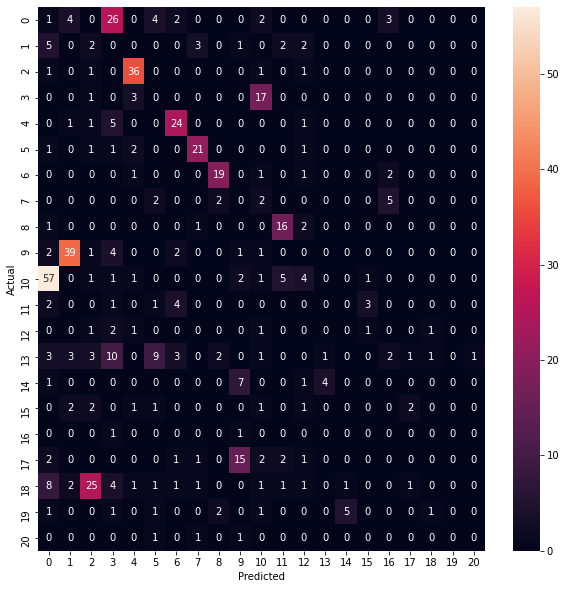


Class Label: [12]
Probability: 0.9978380799293518
Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   2.858580   |  2.788918  |   14.00   |   4.62   
   2    |   2.762574   |  2.743048  |   15.45   |   4.64   
   3    |   2.762494   |  2.684909  |   16.00   |   4.60   
   4    |   2.628099   |  2.671590  |   19.82   |   4.90   
   5    |   2.528895   |  2.499890  |   26.91   |   4.73   
   6    |   2.452886   |  2.590786  |   25.82   |   4.65   
   7    |   2.429832   |  2.574041  |   23.64   |   4.82   
   8    |   2.338492   |  2.524515  |   26.91   |   4.61   
   9    |   2.168952   |  2.514269  |   32.91   |   4.66   
  10    |   2.079044   |  2.616701  |   32.18   |   4.60   
  11    |   1.948094   |  2.099511  |   39.64   |   4.73   
  12    |   1.827781   |  2.264262  |   40.91   |   4.62   
  13    |   1.994155   |  2.483064  |   36.00   |   4.68   
  14    |   1.885684   |  2.4

KeyboardInterrupt: 

In [568]:

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt

idx_splits = list(skf.split(range(len(dataset)), y=labels))

accuracys = []
scores= []

for k, (train_idx, val_idx) in enumerate(idx_splits):
    
    #seed_torch(RANDOM_SEED)
    train_ds = TorchtextSubset(dataset, train_idx)
    val_ds = TorchtextSubset(dataset, val_idx)
    
    
    train_loader, val_loader = data.BucketIterator.splits(
        [train_ds, val_ds], 
        batch_sizes=[BATCH_SIZE,BATCH_SIZE], 
        device=DEVICE,
        sort_key=lambda x: len(x.content),
        sort_within_batch=True)

    INPUT_DIM = len(TEXT.vocab)

    PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

    torch.manual_seed(RANDOM_SEED)
    model = RNN(INPUT_DIM, EMBEDDING_DIM, BIDIRECTIONAL, HIDDEN_DIM, NUM_LAYERS, OUTPUT_DIM, DROPOUT, PAD_IDX)
    model = model.to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    criterion=criterion.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    accuracy=train(model, optimizer,criterion, train_loader, val_loader,10 )
    accuracys.append(accuracy)
    
    model.load_state_dict(torch.load('tut5-model.pt'))
    
    
    train_labels=[example.content for example in val_ds]
    val_labels = [example.classlabel for example in val_ds]
    
    y_pred=predictTen(model,train_labels)
    
    
    val_labels=list(map(int, val_labels))
    #print(list(zip(y_pred,val_labels)))
    score=precision_recall_fscore_support(y_true=val_labels, y_pred=y_pred, labels=target_names, average="weighted")
    scores.append(score[0:3])
    print('--------------- Fold: %2d ---------------------'% (k+1))
    print()
    target_names = list(map(str,target_names))
    print(metrics.classification_report(val_labels, y_pred, target_names=target_names))
    conf_mat = confusion_matrix(val_labels, y_pred)
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(conf_mat, annot=True, fmt='d',
                xticklabels=target_names , yticklabels=target_names )
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    print()

    arr = np.array(scores)
    text = """
     premesso che: nell'attuale contesto di stagnazione degli investimenti la capacità di autofinanziamento delle imprese italiane è certamente diminuita. Questo ha determinato un incremento del fabbisogno finanziario da parte delle aziende produttrici, soprattutto di quelle, come le imprese agricole, che hanno difficoltà strutturali di autofinanziamento. L'indebitamento bancario per il settore agricolo rischia, però, di diventare un onere gravoso, soprattutto in questa fase di difficoltà economica e di restrizione creditizia; numerose sono le imprese agricole in difficoltà economiche, specialmente al Sud, che avrebbero semplicemente necessità di riequilibrare la loro posizione finanziaria attraverso l'accensione di operazioni di ristrutturazione dei loro debiti bancari, ma trovano forti difficoltà ad accedere a questi finanziamenti. Lo Stato e le regioni, per mancanza di risorse e anche per i limiti posti dalla Commissione europea sugli «aiuti di Stato» su operazione di consolidamento o di semplice ristrutturazione finanziaria, non sono stati finora in grado di intervenire; inoltre, alla luce della nuova regolamentazione creditizia prevista da Basilea, che dà particolare importanza alle garanzie come strumenti utili per la mitigazione del rischio, le imprese agricole non possono contare su di un adeguato sistema di garanzie; infine, bisogna sottolineare come i consorzi fidi in agricoltura non hanno ottenuto il successo che si riscontra in altri settori produttivi e sarebbe importante favorire un loro sviluppo e rafforzamento, attraverso anche una politica di agevolazioni al loro accorpamento, per dare una competenza territoriale più ampia ed un bacino di utenza superiore, sia in termini di volumi patrimoniali, che di numero di associati; come è noto, il problema del ricambio generazionale, già molto acuto nell'agricoltura europea, è particolarmente grave in Italia che, con il Portogallo, presenta l'indice di invecchiamento più elevato di tutta l'Unione europea; l'età media dei conduttori di impresa agricola in Italia si attesta sui 58 anni, con punte di 62 anni in caso di imprese che producono esclusivamente per autoconsumo; per favorire il ricambio generazionale servono politiche e regole adeguate e servizi specifici, soprattutto finalizzati all'aggregazione sia all'interno del settore agricolo che nel contesto territoriale in cui le imprese operano, favorendo ogni tipo di integrazione&#8211;: quali iniziative intenda assumere il Governo per facilitare l'accesso al credito delle imprese agricole e il ricambio generazionale, nell'obiettivo di sostenere quelle in difficoltà e quelle che intendono rilanciare la propria attività mediante il ricorso ad investimenti innovativi, favorendo politiche di aggregazione e di integrazione per il ricambio generazionale, anche mediante un corretto e pieno utilizzo dei fondi comunitari destinati ai piani di sviluppo rurale.  (3-00051) (14 maggio 2013)
    """
    
    proba, pred_label = predict_class(model, text)

    print(f'Class Label: {le.inverse_transform([pred_label])}')
    print(f'Probability: {proba}')

print("Overall results of the cross-validation procedure")
print()

print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(accuracys), np.std(accuracys)))
print('\nCV precision: %.3f +/- %.3f' % (np.mean(arr[:,0]), np.std(arr[:,0])))
print('\nCV recall: %.3f +/- %.3f' % (np.mean(arr[:,1]), np.std(arr[:,1])))
print('\nCV f1: %.3f +/- %.3f' % (np.mean(arr[:,2]), np.std(arr[:,2])))

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt

idx_splits = list(skf.split(range(len(dataset)), y=labels))

accuracys = []
scores= []

for k, (train_idx, val_idx) in enumerate(idx_splits):
    
    set_seed(RANDOM_SEED)
    train_ds = TorchtextSubset(dataset, train_idx)
    val_ds = TorchtextSubset(dataset, val_idx)
    
    
    train_loader, val_loader = data.BucketIterator.splits(
        [train_ds, val_ds], 
        batch_sizes=[BATCH_SIZE,BATCH_SIZE], 
        device=DEVICE,
        sort_key=lambda x: len(x.content),
        sort_within_batch=True)

    INPUT_DIM = len(TEXT.vocab)

    PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

    torch.manual_seed(RANDOM_SEED)
    model = RNN(INPUT_DIM, EMBEDDING_DIM, BIDIRECTIONAL, HIDDEN_DIM, NUM_LAYERS, OUTPUT_DIM, DROPOUT, PAD_IDX)
    model = model.to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    criterion=criterion.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    accuracy=train(model, optimizer,criterion, train_loader, val_loader,10 )
    accuracys.append(accuracy)
    
    model.load_state_dict(torch.load('tut5-model.pt'))
    
    
    train_labels=[example.content for example in val_ds]
    val_labels = [example.classlabel for example in val_ds]
    y_pred=predictTen(model,train_labels)
    
    #print(list(zip(val_labels,y_pred,proba)))
    val_labels=list(map(int, val_labels))
    score=precision_recall_fscore_support(y_true=val_labels, y_pred=y_pred, labels=target_names, average="weighted")
    scores.append(score[0:3])
    print('--------------- Fold: %2d ---------------------'% (k+1))
    print()
    target_names = list(map(str,target_names))
    print(metrics.classification_report(val_labels, y_pred, target_names=target_names))
    conf_mat = confusion_matrix(val_labels, y_pred)
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(conf_mat, annot=True, fmt='d',
                xticklabels=target_names , yticklabels=target_names )
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    print()

    arr = np.array(scores)

print("Overall results of the cross-validation procedure")
print()

print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(accuracys), np.std(accuracys)))
print('\nCV precision: %.3f +/- %.3f' % (np.mean(arr[:,0]), np.std(arr[:,0])))
print('\nCV recall: %.3f +/- %.3f' % (np.mean(arr[:,1]), np.std(arr[:,1])))
print('\nCV f1: %.3f +/- %.3f' % (np.mean(arr[:,2]), np.std(arr[:,2])))
    
    
    

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt

idx_splits = list(skf.split(range(len(dataset)), y=labels))

accuracys = []
scores= []

for k, (train_idx, val_idx) in enumerate(idx_splits):
    
    set_seed(RANDOM_SEED)
    train_ds = TorchtextSubset(dataset, train_idx)
    val_ds = TorchtextSubset(dataset, val_idx)
    
    

    INPUT_DIM = len(TEXT.vocab)

    PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

    torch.manual_seed(RANDOM_SEED)
    model = RNN(INPUT_DIM, EMBEDDING_DIM, BIDIRECTIONAL, HIDDEN_DIM, NUM_LAYERS, OUTPUT_DIM, DROPOUT, PAD_IDX)
    model = model.to(DEVICE)
    
    
    model.load_state_dict(torch.load('tut5-model.pt'))
    
    
    train_labels=[example.content for example in val_ds]
    val_labels = [example.classlabel for example in val_ds]
    
    
    
    text = """
     premesso che: nell'attuale contesto di stagnazione degli investimenti la capacità di autofinanziamento delle imprese italiane è certamente diminuita. Questo ha determinato un incremento del fabbisogno finanziario da parte delle aziende produttrici, soprattutto di quelle, come le imprese agricole, che hanno difficoltà strutturali di autofinanziamento. L'indebitamento bancario per il settore agricolo rischia, però, di diventare un onere gravoso, soprattutto in questa fase di difficoltà economica e di restrizione creditizia; numerose sono le imprese agricole in difficoltà economiche, specialmente al Sud, che avrebbero semplicemente necessità di riequilibrare la loro posizione finanziaria attraverso l'accensione di operazioni di ristrutturazione dei loro debiti bancari, ma trovano forti difficoltà ad accedere a questi finanziamenti. Lo Stato e le regioni, per mancanza di risorse e anche per i limiti posti dalla Commissione europea sugli «aiuti di Stato» su operazione di consolidamento o di semplice ristrutturazione finanziaria, non sono stati finora in grado di intervenire; inoltre, alla luce della nuova regolamentazione creditizia prevista da Basilea, che dà particolare importanza alle garanzie come strumenti utili per la mitigazione del rischio, le imprese agricole non possono contare su di un adeguato sistema di garanzie; infine, bisogna sottolineare come i consorzi fidi in agricoltura non hanno ottenuto il successo che si riscontra in altri settori produttivi e sarebbe importante favorire un loro sviluppo e rafforzamento, attraverso anche una politica di agevolazioni al loro accorpamento, per dare una competenza territoriale più ampia ed un bacino di utenza superiore, sia in termini di volumi patrimoniali, che di numero di associati; come è noto, il problema del ricambio generazionale, già molto acuto nell'agricoltura europea, è particolarmente grave in Italia che, con il Portogallo, presenta l'indice di invecchiamento più elevato di tutta l'Unione europea; l'età media dei conduttori di impresa agricola in Italia si attesta sui 58 anni, con punte di 62 anni in caso di imprese che producono esclusivamente per autoconsumo; per favorire il ricambio generazionale servono politiche e regole adeguate e servizi specifici, soprattutto finalizzati all'aggregazione sia all'interno del settore agricolo che nel contesto territoriale in cui le imprese operano, favorendo ogni tipo di integrazione&#8211;: quali iniziative intenda assumere il Governo per facilitare l'accesso al credito delle imprese agricole e il ricambio generazionale, nell'obiettivo di sostenere quelle in difficoltà e quelle che intendono rilanciare la propria attività mediante il ricorso ad investimenti innovativi, favorendo politiche di aggregazione e di integrazione per il ricambio generazionale, anche mediante un corretto e pieno utilizzo dei fondi comunitari destinati ai piani di sviluppo rurale.  (3-00051) (14 maggio 2013)
    """
    y_pred=predictTen(model,train_labels)
    proba, pred_label = predict_class(model, text)

    print(f'Class Label: {pred_label}')
    print(f'Probability: {proba}')
    
    #print(list(zip(val_labels,y_pred,proba)))
    

In [ ]:
print(f'Class Label: {le.inverse_transform([pred_label])}')
print(f'Probability: {proba}')